In [1]:
%matplotlib inline

import arms
import time
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt

In [3]:
# complex problem
random_state = np.random.randint(1, 312414)

arm1 = arms.ArmBernoulli(0.2, random_state=random_state)
arm2 = arms.ArmBernoulli(0.65, random_state=random_state)
arm3 = arms.ArmBernoulli(0.797, random_state=random_state)
arm4 = arms.ArmBernoulli(0.794, random_state=random_state)
arm5 = arms.ArmBernoulli(0.795, random_state=random_state)
arm6 = arms.ArmBernoulli(0.797, random_state=random_state)

MAB = [arm1, arm2, arm3, arm4, arm5, arm6]

In [47]:
# definition of the easy problem (e stands for easy)
random_state = np.random.randint(1, 312414)

arm1_e = arms.ArmBernoulli(0.3, random_state=random_state)
arm2_e = arms.ArmBernoulli(0.8, random_state=random_state)
arm3_e = arms.ArmBernoulli(0.4, random_state=random_state)

MAB_e = [arm1_e, arm2_e, arm3_e]

In [4]:
def UCB1(T, MAB, alpha):
    # sequence of reward
    draws = np.zeros(T, dtype=int)
    reward = np.zeros(T)
    
    # nb of ARMS
    K = len(MAB)
    
    # sum gathered up to time t for each arm drawn
    S = np.zeros(K)
    
    # initialization (need to pull all K arms)
    # i.e for t < K, pull arms(t)
    
    # number of draws of arm a up to time t for each arm
    # initialize it to 1 (because pull each arm at the init step)
    N = np.ones(K)
    for t in range(K):
        reward[t] = MAB[t].sample()
        S[t] += reward[t]
        draws[t] = t
    
    # main loop
    for t in range(K, T):        
        # return best arm
        best_arm = np.argmax(S / N + alpha * np.sqrt(np.log(t) / (2 * N)))
        reward[t] = MAB[best_arm].sample()
        S[best_arm] += reward[t]
        draws[t] = best_arm
        N[best_arm] += 1
    
    return reward, draws

In [15]:
def TS(T, MAB):
    # sequence of reward
    draws = np.zeros(T)
    rewards = np.zeros(T)
    
    # number of arms
    K = len(MAB)
    
    # sum of rewards gathered up to time t
    S = np.zeros(K)
    
    # number of draws of each arm up to time t
    N = np.zeros(K)
    
    for t in range(T):
        best_arm = np.argmax(np.random.beta(S + 1, N - S + 1))
        rewards[t] = MAB[best_arm].sample()
        draws[t] = best_arm
        
        S[best_arm] += rewards[t]
        N[best_arm] += 1
        
    
    return rewards, draws

# NAIVE algorithm is just UCB with alpha = 0
def NAIVE(T, MAB):
    return UCB1(T, MAB, 0)

def regret(reward, mu_max):
    T = len(reward)
    return mu_max * np.arange(1, T + 1) - np.cumsum(reward)

def kl(x, y):
    return x * np.log(x/y) + (1-x) * np.log((1-x)/(1-y))

def oracle(mu_max, MAB):
    K = len(MAB)
    
    C = 0
    
    for k in range(K):
        mean =  MAB[k].mean
        if mean < mu_max:
            C += (mu_max - mean) / kl(mean, mu_max)
    
    return C

In [16]:
reward, draws = UCB1(100, MAB, 1)

n = len(np.unique(draws))
d = len(draws[n:])
cumulative_draws = np.cumsum(draws == np.arange(n)[:,None], axis=1)[:, n:]
cumulative_reward = np.cumsum(cumulative_draws[np.arange(n)] * (draws[n:, np.newaxis] == np.arange(n)).T, axis=1)

In [17]:
# number of draws for each arm
unique_d, counts_d = np.unique(draws, return_counts=True)
dict(zip(unique_d, counts_d))

{0: 2, 1: 10, 2: 17, 3: 18, 4: 29, 5: 24}

In [18]:
nb_arms = len(MAB)
means = [el.mean for el in MAB]
mu_max = np.max(means)

C = oracle(mu_max, MAB)
print("complexity of the complex problem : ", C)

complexity :  273.697074427


In [52]:
nb_arms = len(MAB_e)
means = [el.mean for el in MAB_e]
mu_max_e = np.max(means_e)

C = oracle(mu_max_e, MAB_e)
print("complexity of the easy problem : ", C)

complexity of the easy problem :  1.90546741714


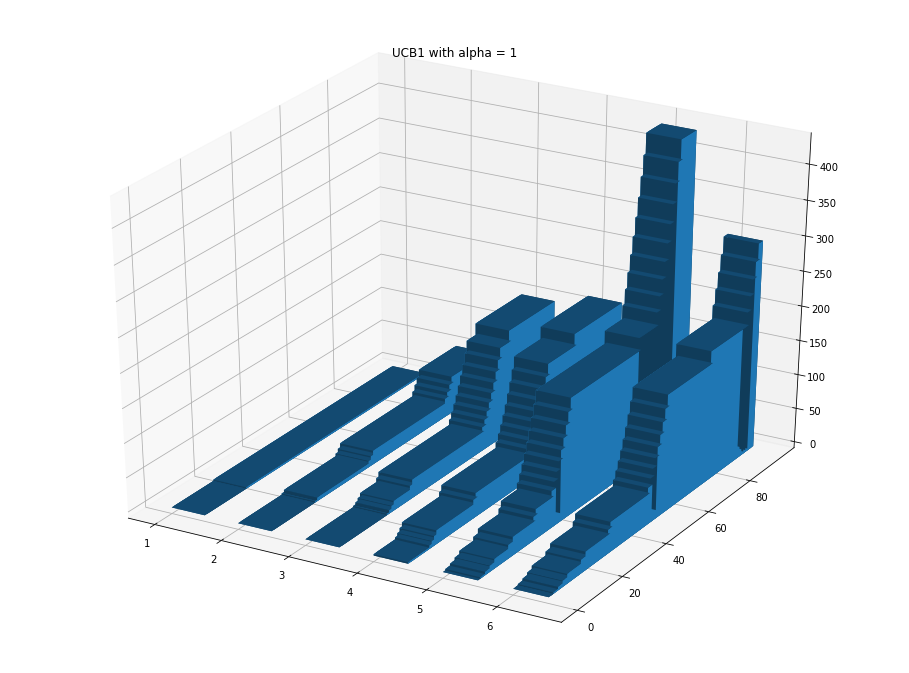

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# setup the figure and axes
fig = plt.figure(figsize=(35, 12))
ax1 = fig.add_subplot(121, projection='3d')

# fake data
_x = np.arange(n) + 1
_y = np.arange(d)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = cumulative_reward.T.flatten()
bottom = np.zeros_like(top)
width = depth = 2

ax1.bar3d(x, y, bottom, 0.5, depth, top)
ax1.set_title("UCB1 with alpha = 1")

### Plotting function

In [39]:
def plot(MAB, algos, alphas, mu_max, nbsimu, T, add_oracle=False):
    temp = np.copy(algos)
    plt.figure(figsize=(15,12))

    sum_rewards = np.array([[0.] * T] * (len(alphas) + len(algos) - 1))
    
    offset = len(alphas)
    
    if 'UCB1' in algos:
        for n in range(nbsimu):
            for i, alpha in enumerate(alphas):
                rewards, _ = UCB1(T, MAB, alpha)
                sum_rewards[i] = sum_rewards[i] + rewards
        
        # plot UCB1
        for i, alpha in enumerate(alphas):
            plt.plot(regret(sum_rewards[i]/nbsimu, mu_max), label="UCB1 with alpha = {}".format(alpha))
    
    algos.remove('UCB1')
    for n in range(nbsimu):
        for i, algo in enumerate(algos):
            rewards, _ = globals()[algo](T, MAB)
            sum_rewards[offset + i] = sum_rewards[offset + i] + rewards
            
    
    # plot for algo != UCB1
    for i, algo in enumerate(algos):
        plt.plot(regret(sum_rewards[offset + i]/nbsimu, mu_max), label="{}".format(algo))
    
    
    # add oracle
    if add_oracle:
        C = oracle(mu_max, MAB)
        plt.plot(C * np.log(np.array(range(T))), label='Lai and Robbins lower bound')
    plt.legend()
    
    # title
    tlt = ", ".join(temp[:-1]) + " AND " + temp[-1]
    if len(temp) == 1:
        tlt = temp[0]
    plt.title("Comparison of Cumulated regret averaged over %d simulations for %s Algorithms" % (nbsimu, tlt))

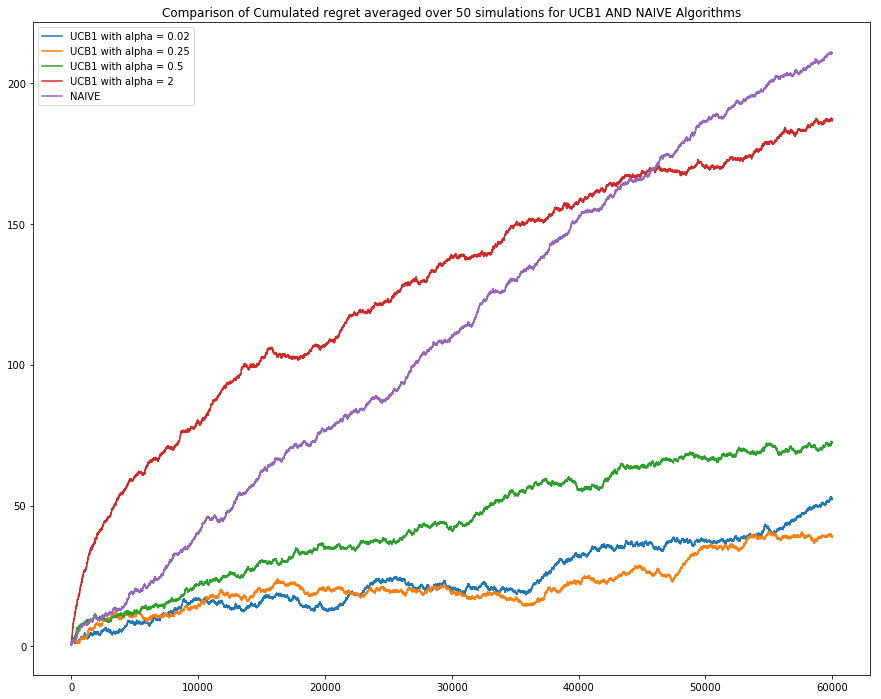

In [50]:
nb_arms = len(MAB)
means = [el.mean for el in MAB]
mu_max = np.max(means)

nbsimu = 50
T = 60000
alphas = [0.02, 0.25, 0.5, 2]
algos = ['UCB1', 'NAIVE']

plot(MAB, algos, alphas, mu_max, nbsimu, T, add_oracle=False)

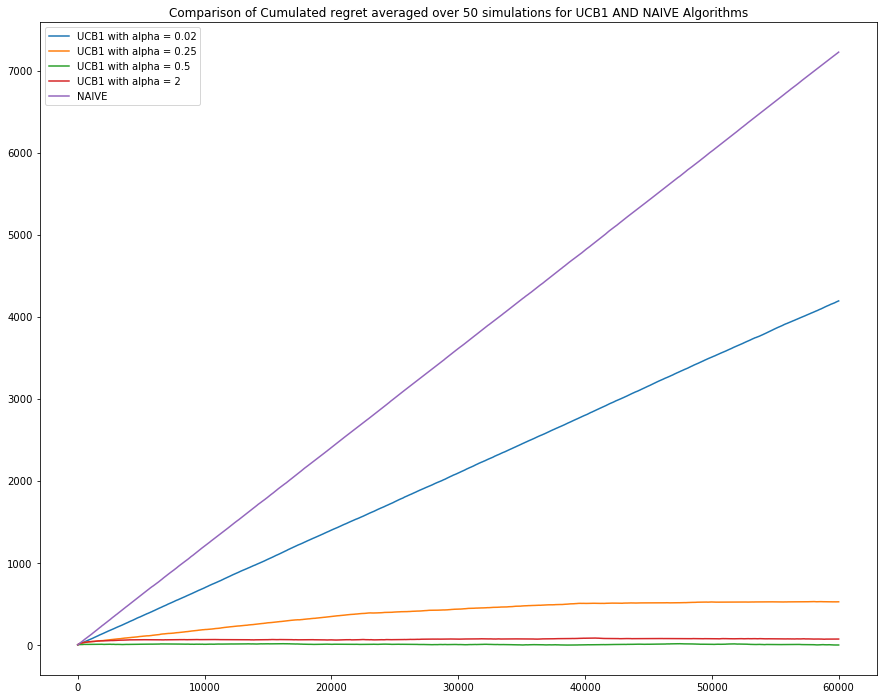

In [48]:
nb_arms = len(MAB_e)
means_e = [el.mean for el in MAB_e]
mu_max = np.max(means_e)

nbsimu = 50
T = 60000
alphas = [0.02, 0.25, 0.5, 2]
algos = ['UCB1', 'NAIVE']

plot(MAB_e, algos, alphas, mu_max, nbsimu, T, add_oracle=False)

## Question 1

###  "Easy" problem

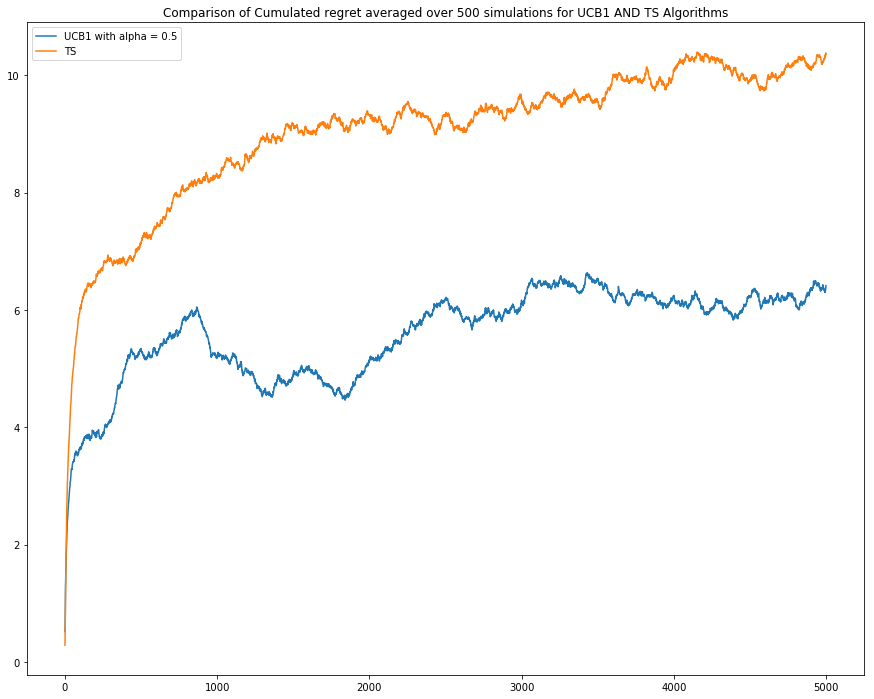

In [60]:
nbsimu = 500
T = 5000
alphas = [0.5]
algos = ['UCB1', 'TS']

plot(MAB_e, algos, alphas, mu_max_e, nbsimu, T, add_oracle=False)

### "Complex" problem

In [61]:
# definition of the complex problem (d stands for difficult)
arm1_d = arms.ArmBernoulli(0.33, random_state=random_state)
arm2_d = arms.ArmBernoulli(0.34, random_state=random_state)
arm3_d = arms.ArmBernoulli(0.36, random_state=random_state)
arm4_d = arms.ArmBernoulli(0.35, random_state=random_state)

MAB_d = [arm1_d, arm2_d, arm3_d, arm4_d]

nb_arms = len(MAB_d)
means_d = [el.mean for el in MAB_d]
mu_max_d = np.max(means_d)

C_d = oracle(mu_max_d, MAB_d)
print("complexity : ", C_d)

complexity :  83.8973783183


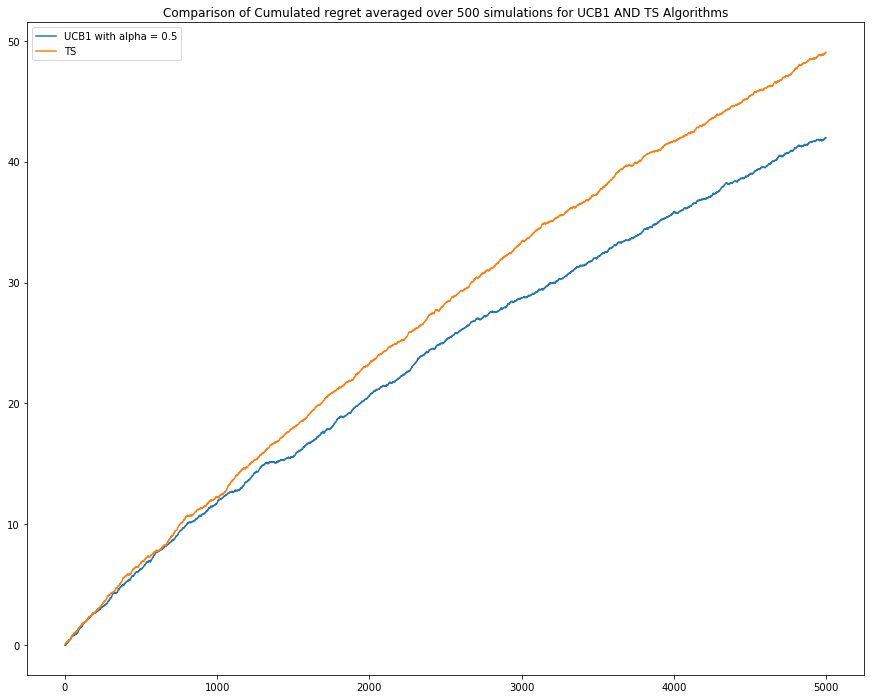

In [62]:
nbsimu = 500
T = 5000
alphas = [0.5] # reusing the best alpha found while comparing UCB1 to Naive
algos = ['UCB1', 'TS']

plot(MAB_d, algos, alphas, mu_max_d, nbsimu, T, add_oracle=False)

### Adding Lai and Robbins bound

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log


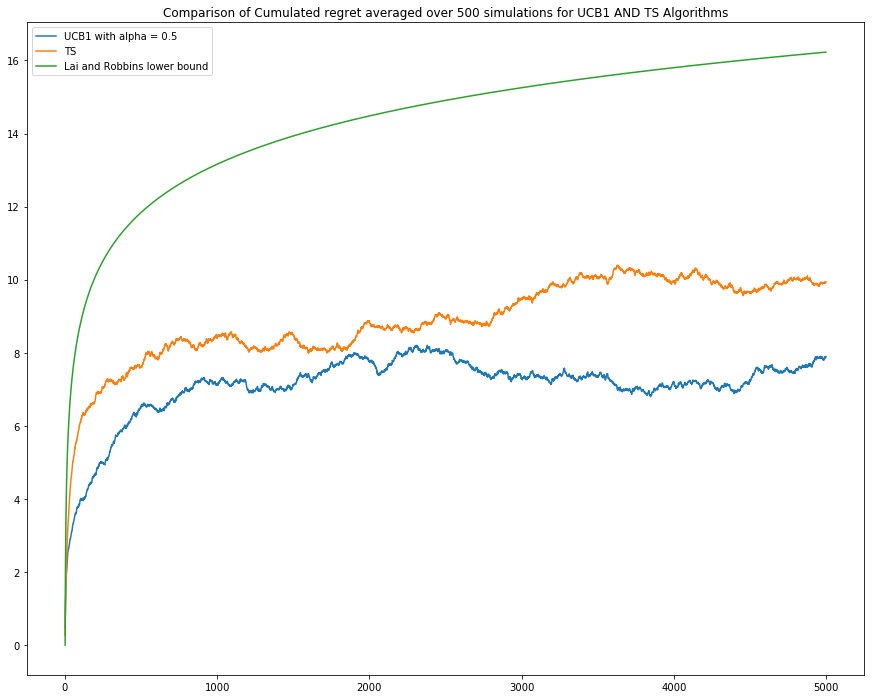

In [63]:
# easy case
nbsimu = 500
T = 5000
alphas = [0.5]
algos = ['UCB1', 'TS']

plot(MAB_e, algos, alphas, mu_max_e, nbsimu, T, add_oracle=True)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: RuntimeWarning: divide by zero encountered in log


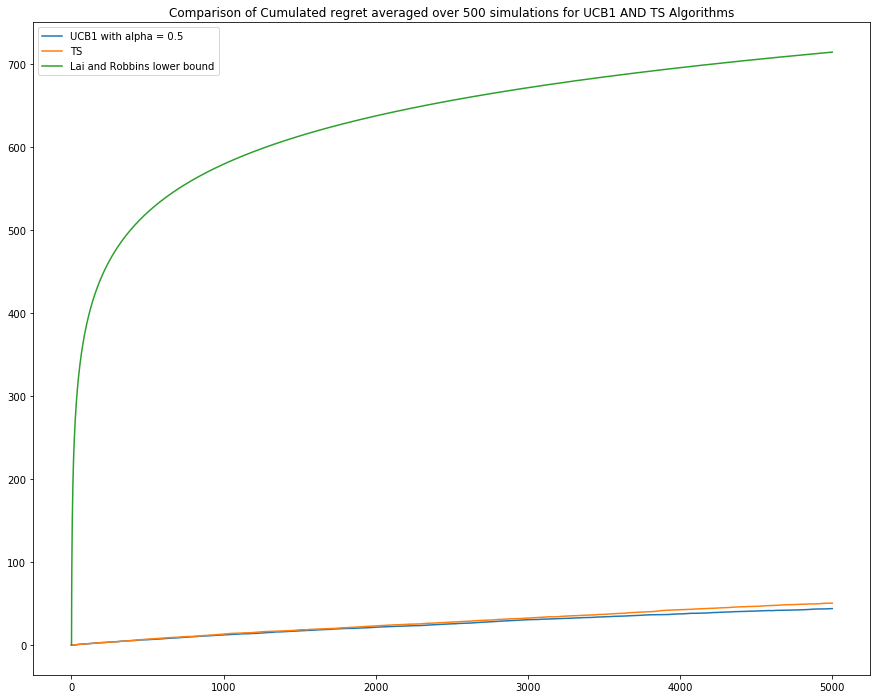

In [64]:
# hard case
nbsimu = 500
T = 5000
alphas = [0.5] # reusing the best alpha found while comparing UCB1 to Naive
algos = ['UCB1', 'TS']

plot(MAB_d, algos, alphas, mu_max_d, nbsimu, T, add_oracle=True)

## 1.2 Non-parametric bandits (bounded rewards)

### 1.  MAB with non Bernoulli arms

In [65]:
# Non Bernoulli arms initialization
MAB_NB = []
for i in range(4):
    MAB_NB.append(arms.ArmExp(i + 2, random_state=random_state))
    print(MAB_NB[i].mean)
    
for i in range(4):
    MAB_NB.append(arms.ArmBeta(i+3, 9-i, random_state=random_state))
    print(MAB_NB[4+i].mean)

MAB_NB.append(arms.ArmBernoulli(0.65, random_state=random_state))
print(MAB_NB[-1].mean)

nb_arms_NB = len(MAB_NB)
means_NB = [el.mean for el in MAB_NB]
mu_max_NB = np.max(means_NB)

C_NB = oracle(mu_max_NB, MAB_NB)
print("complexity : ", C_NB)

0.578258821375
0.350798565497
0.254664340091
0.201356730981
0.25
0.3333333333333333
0.4166666666666667
0.5
0.65
complexity :  18.3978953651


### 2. Adaptation of Thompson Sampling for non-binary rewards

In [66]:
def TSNB(T, MAB):
    # sequence of reward
    draws = np.zeros(T)
    rewards = np.zeros(T)
    
    # number of arms
    K = len(MAB)
    
    # sum of rewards gathered up to time t
    S = np.zeros(K)
    
    # number of draws of each arm up to time t
    N = np.zeros(K)
    
    for t in range(T):
        best_arm = np.argmax(np.random.beta(S + 1, N + 1))
        rewards[t] = MAB[best_arm].sample()
        draws[t] = best_arm
        
        # adapted version
        new_reward = np.random.binomial(1, rewards[t])
        
        
        S[best_arm] += new_reward
        N[best_arm] += 1 - new_reward
        
    
    return rewards, draws

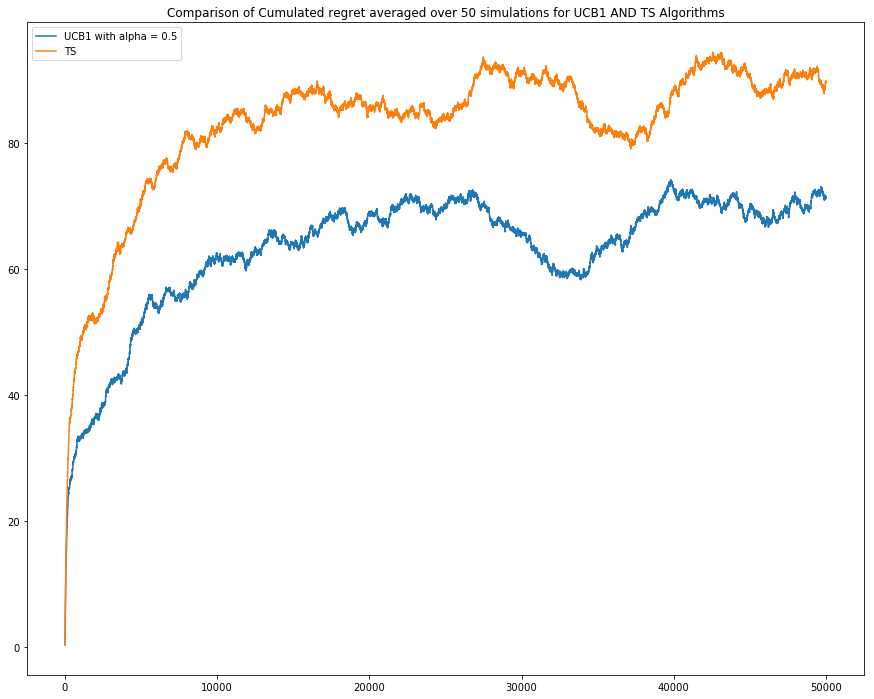

In [68]:
# Non Bernoulli Arms
nbsimu = 50
T = 50000
alphas = [0.5] # reusing the best alpha found while comparing UCB1 to Naive
algos = ['UCB1', 'TS']

plot(MAB_NB, algos, alphas, mu_max_NB, nbsimu, T, add_oracle=False)

## 2 Linear Bandit on Real Data

## 2.3 Implementation of LinUCB

In [2]:
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel

random_state = 42  #np.random.randint(0, 24532523)
model = ColdStartMovieLensModel(
     random_state=random_state,
     noise=0.1
)

In [3]:
def linUCB(T, model, lambd, alpha):
    # return variables
    regret = np.zeros(T)
    norm_dist = np.zeros(T)    
    draws = np.zeros(T, dtype=int)
    rewards = np.zeros(T)
    
    phi = model.features
    
    # K number of arms, d number of features
    K, d = phi.shape
    
    A = np.eye(d,d)
    b = np.zeros(d)
    y = np.zeros(T)
    Z = np.zeros((T, d))
    I = np.eye(d,d)
    
    
    for t in range(T):
        
        A_inv = np.linalg.inv(A)
        theta = A_inv.dot(b)
        
        a_t = np.argmax(phi.dot(theta) + alpha * np.sqrt(np.diag(phi.dot(A_inv).dot(phi.T))))
        
        r_t = model.reward(a_t)
        
        
        y[t] = r_t
        Z[t] = phi[a_t]
    
        # update
        A = Z.T.dot(Z) + lambd * I
        b = Z.T.dot(y)
                        
        # store informations
        regret[t] = model.best_arm_reward() - r_t
        norm_dist[t] = np.linalg.norm(theta - model.real_theta, 2)
        
        draws[t] = a_t
        rewards[t] = r_t
    
    return regret, norm_dist, draws, rewards

In [4]:
# a bit faster implementation
def linUCB2(T, model, lambd, alpha):
    # return variables
    regret = np.zeros(T)
    norm_dist = np.zeros(T)    
    draws = np.zeros(T, dtype=int)
    rewards = np.zeros(T)
    
    phi = model.features
    
    # K number of arms, d number of features
    K, d = phi.shape
    
    A = np.array([np.eye(d,d)] * K)
    b = np.zeros((K, d))
    I = np.eye(d,d)
    P = np.zeros(K)
    theta = np.zeros((K, d))

    # initialization
    A_inv = np.array([np.eye(d,d) * 1/(1+lambd)] * K)
    for a in range(K):
        P[a] = alpha * np.sqrt(phi[a].dot(A_inv[a]).dot(phi[a]))
    
    a_t = None
    
    for t in range(T):

        # STUPID BUG (at the beginning I was doing "if a_t")
        # but if a_t = 0 then it won't enter...
        if a_t is not None: 
            A_inv[a_t] = np.linalg.inv(A[a_t] + lambd * I)
            theta[a_t] = A_inv[a_t].dot(b[a_t])
            P[a_t] = theta[a_t].T.dot(phi[a_t]) + alpha * np.sqrt(phi[a_t].dot(A_inv[a_t]).dot(phi[a_t]))
        
        a_t = np.argmax(P)
        r_t = model.reward(a_t)
        
        # update A and b
        A[a_t] += np.outer(phi[a_t], phi[a_t])        
        b[a_t] += phi[a_t] * r_t
        
        # store informations
        regret[t] = model.best_arm_reward() - r_t
        norm_dist[t] = np.linalg.norm(theta - model.real_theta, 2)
        
        draws[t] = a_t
        rewards[t] = r_t
    
    return regret, norm_dist, draws, rewards

In [65]:
T = 6000
t = time.time()
# stupid theoretical formula for alpha ! alpha = 0.2 is the best !
delta = 1e-3
K, _ = model.features.shape
alpha = np.sqrt(0.5 * np.log((2 * T * K) / delta))
regret_lin, dist_lin, draws_lin, rewards_lin = linUCB(T, model, 2, 0.5)

elapsed = time.time() - t
print("computational time: %.2f " % elapsed)

computational time: 3.24 


In [66]:
model.real_theta

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375])

In [67]:
best_idx = np.argsort(np.dot(model.features, model.real_theta))[::-1]
values = np.dot(model.features, model.real_theta)
print('Best real arm: ', best_idx[0], "\nassociated value: ", values[best_idx[0]], '\n')
print('2nd best real arm: ', best_idx[1], "\nassociated value: ", values[best_idx[1]])

Best real arm:  198 
associated value:  8.7555895471 

2nd best real arm:  204 
associated value:  6.92731743679


In [68]:
# best arms in decreascing order
best_idx

array([198, 204, 206, 108,  65,  40,  24, 196, 111, 205,  14, 199, 120,
        33, 109, 126,  94, 191,  36, 157, 102,  90,  19,  28, 134, 110,
       117, 203,  58,  97, 112, 174, 137, 200,  51,  79,  91,  61, 184,
        99,  98, 172,  64,   8,  38, 193, 105, 156, 178, 139,   3, 136,
       100, 113, 133, 189,  22, 197,  96,  89,  16,  37, 158,   2,  92,
        31,   5,  20, 118, 128, 143, 116,  77, 132,  59, 180,  73,  68,
        62, 201, 187,  75,  21, 202, 153,  18, 161,  88,  43, 119, 141,
        27,  53, 195, 150,  81, 145, 169, 131,  54, 146,   9,  56, 177,
       144, 107, 173, 104,  83, 151, 192, 190,  34, 185, 159, 106,  76,
       155,  78, 138, 121,  29,   1,  67,  39, 194, 148, 124, 129, 188,
        48,  87,  49, 123, 140,  57,  42,  46,  85, 127, 170,  17, 162,
       154,  82,  26, 152, 125,  66, 168,  93, 114, 175,  30,  80, 103,
       130, 142,  45,  63, 171, 135,  74,  86,  52,  12,  50, 163,  47,
        10,  41,  60, 181,  72,  71, 101,   4, 186, 122,  69,  1

In [69]:
# display how many time each action is chosen
unique, counts = np.unique(draws_lin, return_counts=True)
print("Arms, Nb of pulls")
dict(zip(unique, counts))

Arms, Nb of pulls


{8: 1,
 12: 1,
 25: 1,
 28: 1,
 33: 5959,
 41: 1,
 55: 1,
 58: 32,
 69: 1,
 167: 1,
 172: 1}

In [83]:
list(best_idx).index(172)

41

## Random policy

In [10]:
def linRandom(T, model, lambd):
    # return variables
    regret = np.zeros(T)
    norm_dist = np.zeros(T)    
    draws = np.zeros(T, dtype=int)
    rewards = np.zeros(T)
    
    phi = model.features
    
    # K number of arms, d number of features
    K, d = phi.shape
    
    A = np.eye(d,d)
    b = np.zeros(d)
    y = np.zeros(T)
    Z = np.zeros((T, d))
    I = np.eye(d,d)
    
    for t in range(T):

        theta = np.linalg.solve(A, b)
            
        a_t = np.random.randint(K)
        r_t = model.reward(a_t)
        
        y[t] = r_t
        Z[t] = phi[a_t]
        
        # update A and b
        A = Z.T.dot(Z) + lambd * I
        b = Z.T.dot(y)
        
        # store informations
        regret[t] = model.best_arm_reward() - r_t
        norm_dist[t] = np.linalg.norm(theta - model.real_theta, 2)
        
        draws[t] = a_t
        rewards[t] = r_t
    
    return regret, norm_dist, draws, rewards

## $\epsilon$-greedy

In [11]:
def linEpsGreedy(T, model, lambd, eps):
    # return variables
    regret = np.zeros(T)
    norm_dist = np.zeros(T)    
    draws = np.zeros(T, dtype=int)
    rewards = np.zeros(T)
    
    phi = model.features
    
    # K number of arms, d number of features
    K, d = phi.shape
    
    A = np.eye(d,d)
    b = np.zeros(d)
    y = np.zeros(T)
    Z = np.zeros((T, d))
    I = np.eye(d,d)
    
    # for epsilon greedy and efficiency do it that way
    greedy_table = np.random.binomial(1, 1 - eps, T)
    
    for t in range(T):
        
        A_inv = np.linalg.inv(A)
        theta = A_inv.dot(b)
        
        a_t = np.random.randint(K)
        if greedy_table[t]:
            a_t = np.argmax(phi.dot(theta))
            
        r_t = model.reward(a_t)
        
        y[t] = r_t
        Z[t] = phi[a_t]
        
        # update A and b
        A = Z.T.dot(Z) + lambd * I
        b = Z.T.dot(y)
        
        # store informations
        regret[t] = model.best_arm_reward() - r_t
        norm_dist[t] = np.linalg.norm(theta - model.real_theta, 2)
        
        draws[t] = a_t
        rewards[t] = r_t
    
    return regret, norm_dist, draws, rewards

## Final results

Simulating linEpsGreedy: 100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


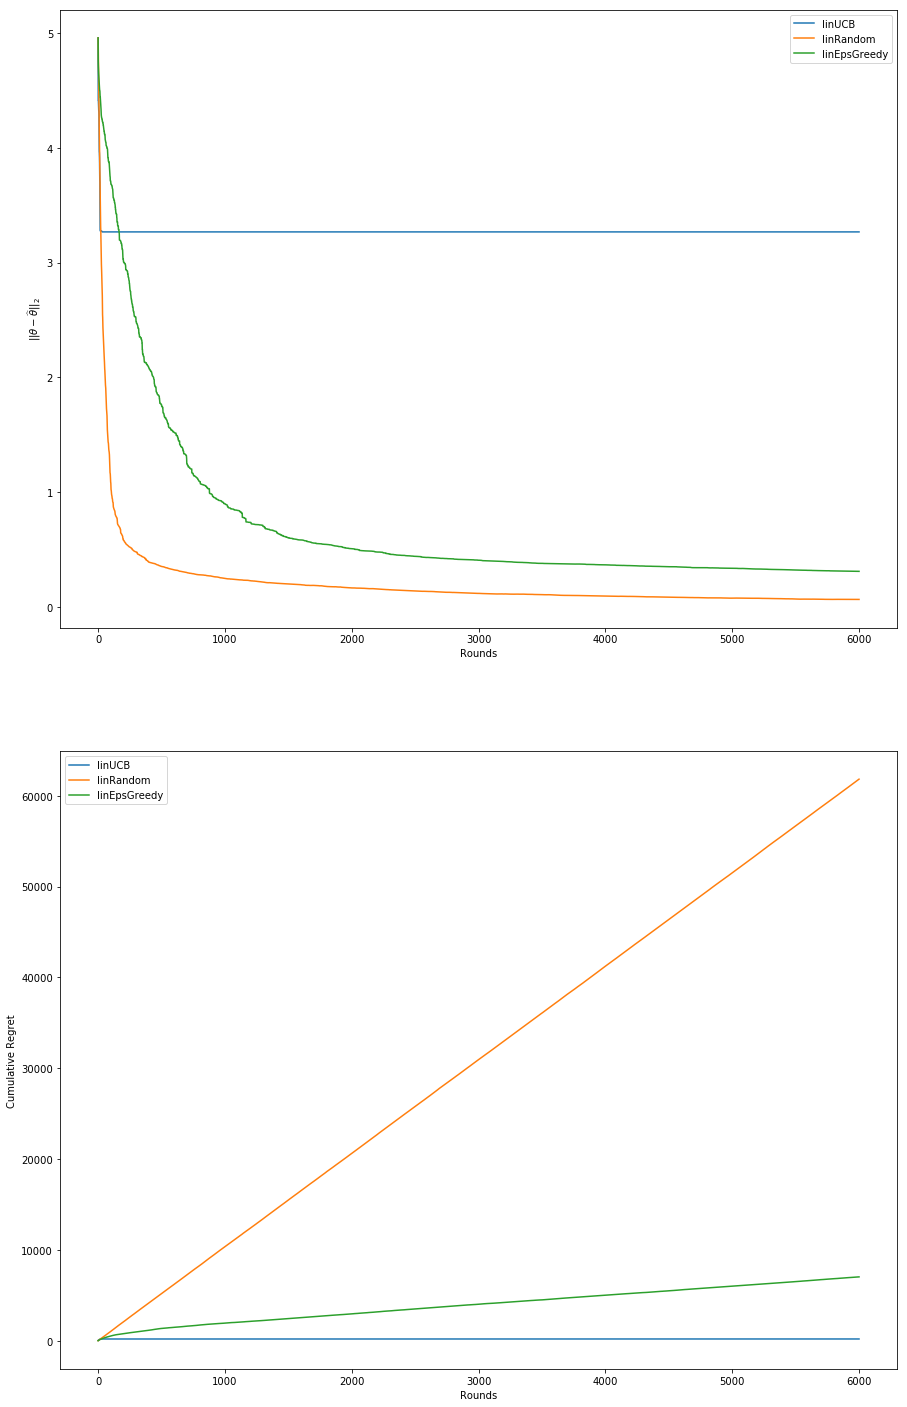

In [18]:
from tqdm import tqdm

random_state = np.random.randint(0, 24532523)

T = 6000
nb_simu = 20
eps = 0.1
lambd = 2

delta = 1e-3
K, _ = model.features.shape
alpha = np.sqrt(0.5 * np.log((2 * T * K) / delta))


algos = ['linUCB', 'linRandom', 'linEpsGreedy']
algos_param = [(T, model, lambd, alpha), (T, model, lambd), (T, model, lambd, eps)]
nb_alg = len(algos)

regret = np.zeros((nb_alg ,nb_simu, T))
norm_dist = np.zeros((nb_alg, nb_simu, T))

for i, (alg_name, alg_param) in enumerate(zip(algos, algos_param)):
    for k in tqdm(range(nb_simu), desc="Simulating {}".format(alg_name)):

        regret_linUCB, dist_linUCB, _, _ = globals()[alg_name](*alg_param)

        regret[i, k, :] = regret_linUCB
        norm_dist[i, k, :] = dist_linUCB

# compute average (over sim) of the algorithm performance and plot it
mean_norms = np.mean(norm_dist, axis=1)
mean_regret = np.mean(regret, axis=1)

f, ax = plt.subplots(2, 1, figsize=(15,25))
for i, alg_name in enumerate(algos):
    ax[0].plot(mean_norms[i], label=alg_name)
    ax[0].set_ylabel(r'$||\theta - \widehat{\theta}||_2$')
    ax[0].set_xlabel('Rounds')

    ax[1].plot(np.cumsum(mean_regret[i]), label=alg_name)
    ax[1].set_ylabel('Cumulative Regret')
    ax[1].set_xlabel('Rounds')

ax[0].legend()
ax[1].legend()

In [120]:
t = time.time()

delta = 1e-3
K, _ = model.features.shape
T = 6000
alpha = np.sqrt(0.5 * np.log((2 * T * K) / delta))

regret_lin, dist_lin, draws_lin, rewards_lin = linEpsGreedy(T, model, 2, 0.01)

elapsed = time.time() - t
print("computational time: %.2f " % elapsed)

computational time: 2.60 


In [121]:
best_idx = np.argsort(np.dot(model.features, model.real_theta))[::-1]
values = np.dot(model.features, model.real_theta)
print('Best real arm: ', best_idx[0], "\nassociated value: ", values[best_idx[0]], '\n')
print('2nd best real arm: ', best_idx[1], "\nassociated value: ", values[best_idx[1]])

Best real arm:  198 
associated value:  8.7555895471 

2nd best real arm:  204 
associated value:  6.92731743679


In [122]:
# display how many time each action is chosen
unique, counts = np.unique(draws_lin, return_counts=True)
print("Arms, Nb of pulls")
dict(zip(unique, counts))

Arms, Nb of pulls


{0: 2,
 1: 1,
 13: 2,
 14: 1,
 15: 1,
 16: 1,
 18: 1,
 22: 1,
 23: 1,
 24: 1,
 30: 2,
 38: 1,
 39: 1,
 40: 1,
 45: 1,
 46: 1,
 55: 2,
 57: 1,
 67: 1,
 69: 1,
 70: 1,
 71: 1,
 73: 1,
 74: 1,
 86: 1,
 87: 1,
 90: 1,
 95: 1,
 100: 1,
 102: 1,
 104: 1,
 109: 1,
 120: 1,
 122: 1,
 123: 1,
 124: 1,
 135: 1,
 139: 2,
 140: 1,
 141: 1,
 144: 1,
 151: 1,
 157: 1,
 168: 1,
 172: 234,
 176: 1,
 181: 1,
 186: 1,
 187: 1,
 195: 1,
 197: 2,
 198: 5708,
 203: 2}

In [133]:
list(best_idx).index(30)

153